<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>


# Coupled landscape-life evolution modeling

In this notebook we explore links between landscape and life evolution using the Landlab component, SpeciesEvolver.

## Example model: climate change impacts on species distribution and evolution

### Premise

Ecosystems zonate by elevation in large part because surface air temperature decreases with altitude. Long term temperature change alters the landscape connectivity within elevations zones, therefore we ask: ***How is vegetation macroevolution impacted by temperature changes?***

### Summary

In this model, we

* Set surface air temperture across a model grid as a function of elevation.
* Populate species within the grid. These species exist within a fixed temperature interval.
* Simulate three time steps where surface air temperature has changed in the latter two steps, and species respond to this change.
* Examine how the number of species, "species richness" changes as the model progresses.

## Import modules

The zones of ZoneSpecies are managed by a `ZoneController`, so we must import this class along with the SpeciesEvolver component and the other modules used in this notebook.

In [1]:
from landlab.components import SpeciesEvolver, Profiler
from landlab.components.species_evolution import ZoneController
from landlab.io import read_esri_ascii
from landlab.plot import imshow_grid
import matplotlib.pyplot as plt
import numpy as np

## Prepare the grid

### Load topography

Topography of the model grid is loaded from a file. The topography was previously developed using a model built with Landlab. An initial surface was uplifted, stream erosion was conducted using the FastscapeEroder component, and hillslope diffusion was conducted using the LinearDiffuser component. The model was run until topography reached steady state.

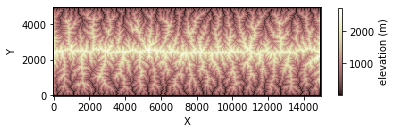

In [2]:
# Create a model grid and set a topographic elevation field.
(mg, z) = read_esri_ascii('model_grid_steady_state_elevation.txt')
mg.at_node['topographic__elevation'] = z

# Set the top and bottom grid boundaries to open.
mg.set_closed_boundaries_at_grid_edges(
    right_is_closed=True,
    top_is_closed=False,
    left_is_closed=True,
    bottom_is_closed=False
)

# Plot the elevation field.
imshow_grid(mg, 'topographic__elevation', colorbar_label='elevation (m)', shrink=0.4)

### Create a grid field of air temperature at the land surface

We set the surface air temperature at base level (upper and lower boundaries). We use a lapse rate to create a  surface air temperature field at all grid nodes. The lapse rate, *L* is modeled as the decrease of temperature, *T* with increasing elevation, *z* as

\begin{align*}
L = -\frac{\delta t}{\delta z}
\end{align*}

We use a constant lapse rate of -6&deg;C / km.

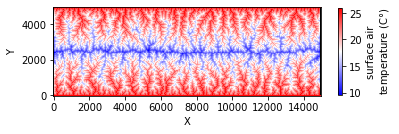

In [3]:
# Set a rate of temperature decrease per meter of elevation increase.
lapse_rate = -0.006

# Create a surface temperature field.
temperature_at_base_level = 26
T = lapse_rate * z + temperature_at_base_level
mg.add_field('node', 'land_surface_air__temperature', T)

# Plot temperature field.
imshow_grid(
    mg, 'land_surface_air__temperature',
    colorbar_label='surface air\ntemperature (C$\degree$)',
    shrink=0.4, cmap='bwr'
)

## Setup SpeciesEvolver and zones

The general workflow of working with zones and zone-based species using SpeciesEvolver is

* Intialize the SpeciesEvolver component.
* Setup zones and zone-based species:
    * Define a function that identifies the grid nodes where all zones will be created.
    * Intialize a ZoneController that will create and manage zones.
    * Populate zones with species.
* Introduce species to SpeciesEvolver so the component will track them over time.

### Initialize SpeciesEvolver

This component requires only one parameter, a model grid.

In [4]:
se = SpeciesEvolver(mg)

View `record_data_frame` of our SpeciesEvolver instance. Time and other model variables are stored in the attribute that is a Pandas DataFrame. The first and second columns are the row number and model time, respectively. We also see that 0 species exist. We have yet to introduce species.

In [5]:
se.record_data_frame

,time,species_count
0,0,0


### Create a zone function

The zone function identifies all grid nodes where zones are to be created. A zone is created for each cluster of spatially continuous nodes.

The zone function has the following two requirements:
1. It must return a boolean numpy array equal to the grid's `number_of_nodes`.
2. The first parameter must be named `grid`. It is the same Landlab grid supplied to SpeciesEvolver. Additional parameters are allowed.

For the model in this tutorial, we define a zone function that indicates zones should be created where the air temperature is between 15&deg;C and 25&deg;C, inclusive.

In [6]:
def zone_func(grid):
    """Get a mask of the total zone extent."""
    T = grid.at_node['land_surface_air__temperature']
    T_max = 25
    T_min = 15
    zone_extent_mask = np.all([T >= T_min, T <= T_max], 0)
    return zone_extent_mask

To demonstrate the output of this function, `True` values are shaded white in the plot below. Zones will be created in the masked area (in white).

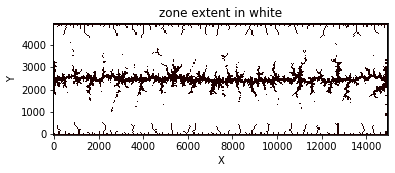

In [7]:
imshow_grid(mg, zone_func(mg), allow_colorbar=False, plot_name='zone extent in white')

### Initialize ZoneController

Next, we instantiate a ZoneController that will create and manage the zones. We use an optional parameter, `minimum_area` to indicate the minimum area of the zones to be created. Zones will be created upon initialization of this controller.

In [8]:
zc = ZoneController(mg, zone_func, minimum_area=50000)

Above, the mask returned by the `zone_func` indicates where zones should be created.

Below, we see ZoneController created two zones, one for each spatially distinct node cluster in the `zone_func` mask.

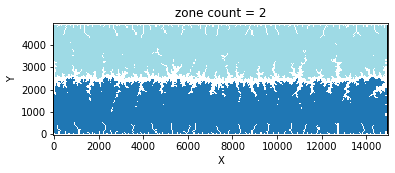

In [9]:
# Create a map of all zones.
zone_map = np.zeros(mg.number_of_nodes)
for i, zone in enumerate(zc.zones):
    zone_map[zone.mask] = i + 1

# Plot zone map.
cmap = plt.cm.tab20
cmap.set_under('w')
title = 'zone count = {}'.format(len(zc.zones))
imshow_grid(mg, zone_map, cmap=cmap, allow_colorbar=False, plot_name=title, vmin=1)

Multiple instances of ZoneController may be used with the same instance of SpeciesEvolver. This is useful when you wish to model groups of species where each group needs a different `zone_func`, for instance, fish and bears.

### Seed zones with species

In this model, a species is populated to each of the two initial zones using the ZoneController method, `populate_zones_uniformly`. This method creates species and populates it to each zone.

In [10]:
species = zc.populate_zones_uniformly(1)

### Introduce species to SpeciesEvolver

All species must be introduced using the SpeciesEvolver method, `introduce_species` in order for the species to be tracked by SpeciesEvolver.

In [11]:
se.introduce_species(species)

Two species now exist in SpeciesEvolver.

In [12]:
se.record_data_frame

,time,species_count
0,0,2


The SpeciesEvolver attribute, `species_data_frame` provides data about all of the introduced species, both extant and extinct. The data is presented in a Pandas DataFrame. The `clade` and `number` identifier elements are explained next.

In [13]:
se.species_data_frame

,clade,number,time_appeared,latest_time
0,A,0,0,0
1,B,0,0,0


### Plot initial profiles

Plot profile across the main ridgeline.

(0.0, 3000.0, 200, 2294.2755362819244)

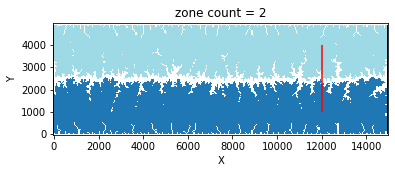

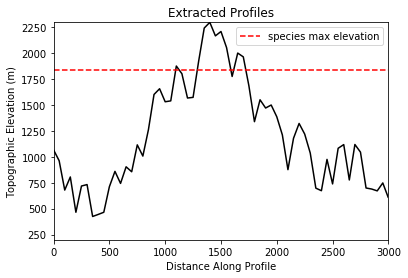

In [14]:
# Plot profile.

endpoints = [24240, 6240]
profiler = Profiler(mg, endpoints)
profiler.run_one_step()
profiler.plot_profiles_in_map_view(
    color='r', field=zone_map, cmap=cmap,
    allow_colorbar=False, plot_name=title, vmin=1
)

plt.figure()
profiler.plot_profiles(ylabel='Topographic Elevation (m)', color='black')

# Include species min elevation line.

z_max = (15 - temperature_at_base_level) / lapse_rate
plt.plot([0, 3000], [z_max, z_max], 'r--', label='species max elevation')
plt.legend()
plt.axis(ymin=200)

## Model time step 1

Initial conditions were established in time 0. Next, climate change is modeled by increasing the temperature at base level by 6&deg;C.

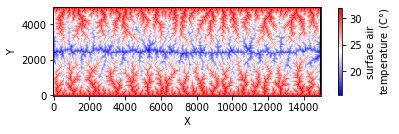

In [15]:
# Update the temperature field.
temperature_at_base_level += 6
mg.at_node['land_surface_air__temperature'] = lapse_rate * z + temperature_at_base_level

# Plot the temperature field.
imshow_grid(
    mg, 'land_surface_air__temperature',
    colorbar_label='surface air\ntemperature (C$\degree$)',
    shrink=0.4, cmap='bwr'
)

Here we advance ZoneController and SpeciesEvolver in time by one time step. ZoneController is advanced first in order to update the zones prior to calling SpeciesEvolver.

`dt` is set to 1 only because the duration of a time step is not prescribed in this tutorial. This `1` does not signify that one time step is run. We use 1 to make it simple to think about the time step sequence. Often, you may wish to make `dt` be the number of years in a time step.

In [16]:
dt = 1
zc.run_one_step(dt)
se.run_one_step(dt)

One zone now exists because the temperature increase raised the area that falls within the temperature range prescribed in `zone_func`.

Plot the zones.

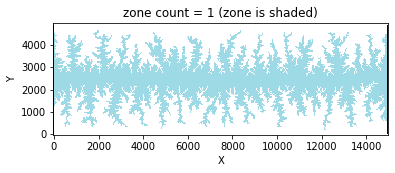

In [17]:
# Create a map of all zones.
zone_map = np.zeros(mg.number_of_nodes)
for i, zone in enumerate(zc.zones):
    zone_map[zone.mask] = i + 1

# Plot zone map.
title = 'zone count = {} (zone is shaded)'.format(len(zc.zones))
imshow_grid(mg, zone_map, cmap=cmap, allow_colorbar=False, plot_name=title, vmin=0.5)

A 'many-to-one' zone connectivity occurred in this time step relative to the previous time step, meaning neither speciation or extinction were triggered by zone change. (See zone connectivity table above.)

The same two species of time 0 exist in time 1. Their geographic range is all that changed.

In [18]:
se.species_data_frame

,clade,number,time_appeared,latest_time
0,A,0,0,1
1,B,0,0,1


### Plot profiles

Plot profile across the main ridgeline.

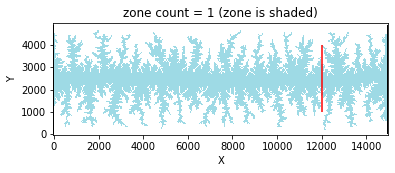

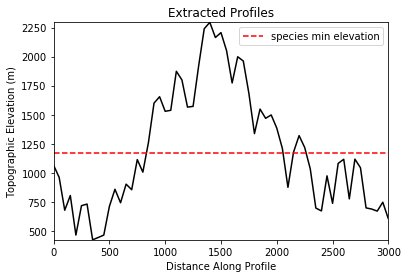

In [19]:
# Plot profile.

endpoints = [24240, 6240]
profiler = Profiler(mg, endpoints)
profiler.run_one_step()
profiler.plot_profiles_in_map_view(
    color='r', field=zone_map, cmap=cmap,
    allow_colorbar=False, plot_name=title, vmin=0.5
)

plt.figure()
profiler.plot_profiles(ylabel='Topographic Elevation (m)', color='black')

# Include species min elevation line.

z_min = (25 - temperature_at_base_level) / lapse_rate
plt.plot([0, 3000], [z_min, z_min], 'r--', label='species min elevation')
_ = plt.legend()

Plot profile parallel to main ridge line.

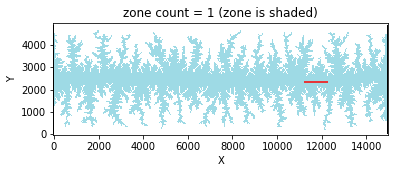

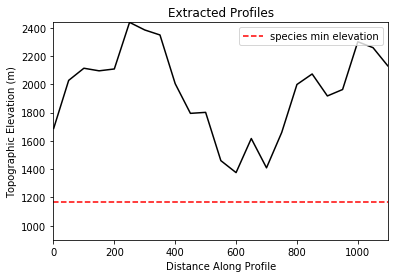

In [20]:
# Plot profile.

endpoints = [14324, 14346]
profiler = Profiler(mg, endpoints)
profiler.run_one_step()
profiler.plot_profiles_in_map_view(
    color='r', field=zone_map, cmap=cmap,
    allow_colorbar=False, plot_name=title, vmin=0.5
)

plt.figure()
profiler.plot_profiles(ylabel='Topographic Elevation (m)', color='black')

# Include species min elevation line.

z_min = (25 - temperature_at_base_level) / lapse_rate
plt.plot([0, 3000], [z_min, z_min], 'r--', label='species min elevation')
plt.legend()
_ = plt.axis(ymin=900)

## Model time step 2

Temperature is again increased by 6&deg;C in time step 2.

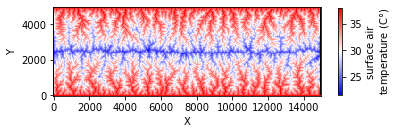

In [21]:
# Update the surface temperature field.
temperature_at_base_level += 6
mg.at_node['land_surface_air__temperature'] = lapse_rate * z + temperature_at_base_level

# Plot temperature field.
imshow_grid(
    mg, 'land_surface_air__temperature',
    colorbar_label='surface air\ntemperature (C$\degree$)',
    shrink=0.4, cmap='bwr'
)

Advance ZoneController and SpeciesEvolver, and plot zones.

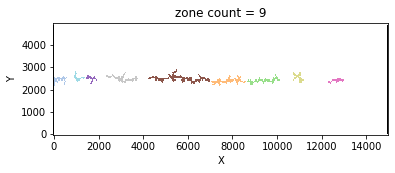

In [22]:
zc.run_one_step(dt)
se.run_one_step(dt)

# Create a map of all zones.
zone_map = np.zeros(mg.number_of_nodes)
for i, zone in enumerate(zc.zones):
    zone_map[zone.mask] = i + 1

# Plot zone map.
title = 'zone count = {}'.format(len(zc.zones))
imshow_grid(mg, zone_map, cmap=cmap, allow_colorbar=False, plot_name=title, vmin=0.5)

Nine zones exist now. The effect of this `one-to-many` zone connectivity change on species is examined in the next section.

### Plot profiles

Plot profile along the main ridgeline.

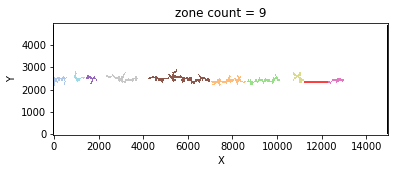

In [23]:
endpoints = [14324, 14346]
profiler = Profiler(mg, endpoints)
profiler.run_one_step()
profiler.plot_profiles_in_map_view(
    color='r', field=zone_map, cmap=cmap,
    allow_colorbar=False, plot_name=title, vmin=0.5
)

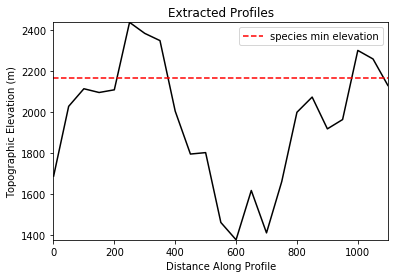

In [24]:
profiler.plot_profiles(ylabel='Topographic Elevation (m)', color='black')

z_min = (25 - temperature_at_base_level) / lapse_rate
plt.plot([0, 2500], [z_min, z_min], 'r--', label='species min elevation')
_ = plt.legend()

## Model complete: examine the species

In the species DataFrame, we see 20 species existed during the model. Species A.0 and B.0 are known to exist as late as time 1. All other species appeared at time 2, the final time step. Something happened between time steps 1 and 2 when A.0 and B.0 went extinct and 18 other species were created.

In [25]:
se.species_data_frame

,clade,number,time_appeared,latest_time
0,A,0,0,1
1,A,1,2,2
2,A,2,2,2
3,A,3,2,2
4,A,4,2,2
5,A,5,2,2
6,A,6,2,2
7,A,7,2,2
8,A,8,2,2
9,A,9,2,2


In the SpeciesEvolver record DataFrame, we see 18 speciations, meaning they occurred before this time step and after the prior time step. We also see two pseudoextinctions were recognized at time 2. A pseudoextinction is a species that is no longer extant because it speciated into child species.

In [26]:
se.record_data_frame

,time,species_count,speciation_count,extinction_count,pseudoextinction_count
0,0,2,NaN,NaN,NaN
1,1,2,0.0,0.0,0.0
2,2,18,18.0,0.0,2.0


A summary of the species in this model:

- A.0 and B.0: The initial species we introduced.
- A.1...9 and B.1...9: The child species of the initial species.

We will examine the model history using the plot below

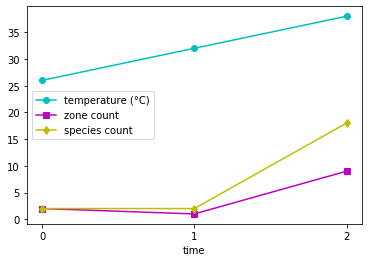

In [27]:
# Create a plot of key model variables over time.

time = se.record_data_frame.time
temperature = [26, 32, 38]
n_zones = zc.record_data_frame.zone_count
n_species = se.record_data_frame.species_count

plt.plot(time, temperature, 'o-c', label='temperature (\N{DEGREE SIGN}C)')
plt.plot(time, n_zones, 's-m', label='zone count')
plt.plot(time, se.record_data_frame.species_count, 'd-y', label='species count')
plt.xlabel('time')
plt.xticks(time)
_ = plt.legend()

The model begins at time 0 with two zones, each with one of the initial species, A.0 and B.0. Zone count decreases by one in time 1 as the temperature increased. Species and zone count drastically increases in time 2 as temperature continued to increase. The schematic profiles of topography below illustrate species distribution and count in response to temperature change over the model time.

SpeciesEvolver automatically creates a `species_richness` grid field. We can use this field to see that there are two species in each zone. (species richness = number of species) In each zone, one species belongs to clade A, the other belongs to clade B.

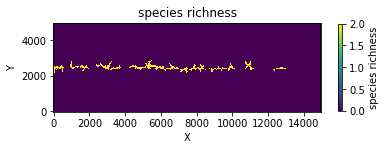

In [28]:
imshow_grid(
    mg, 'species__richness', plot_name='species richness',
    colorbar_label='species richness', shrink=0.4, cmap='viridis'
)

Similar to SpeciesEvolver, ZoneController has a `record_data_frame` that stores model variables over time. The ZoneController stores variables pertinent to zones.

In the ZoneController record, 'fragmentation_count' in time 2 is nine. The one zone in time 1 split into nine fragments, or zones, essentially between times 1 and 2.

We see capture statistics in this record as well. Here, a capture indicates that a zone captured area from a zone in a prior time step. The one zone in time 1 captured the two zones in time 0.

In [29]:
zc.record_data_frame

,time,zone_count,fragmentation_count,capture_count,area_captured_sum,area_captured_max
0,0,2,NaN,NaN,NaN,NaN
1,1,1,0.0,1.0,32542500.0,32542500.0
2,2,9,9.0,0.0,0.0,0.0


Pandas DataFrame methods can be used on `record_data_frame`. For example, here we get the maximum capture count.

In [30]:
zc.record_data_frame.zone_count.max()

9

## Obtaining specific species objects

Metadata of species can be viewed in `species_data_frame`, although species objects cannot be obtained from this DataFrame. Species objects are obtained using the SpeciesEvolver method, `filter_species`. With species objects you can work with individual species, including plotting its geographic range as demonstrated below.

All of the introduced species and their child species are returned when no parameters are inputted into `filter_species`. This method returns the 20 species that have existed in this notebook's SpeciesEvolver instance.

In [31]:
filtered_species = se.filter_species()
filtered_species

The species can be filtered by the time they existed. To do so, we can use the optional parameter, `time` to indicate we want the species extant at time 0.

In [32]:
filtered_species = se.filter_species(time=0)
filtered_species

We can confirm that this method returned the first two species introduced at time 0, A.0 and B.0.

In [33]:
[s.identifier for s in filtered_species]

[('A', 0), ('B', 0)]

The species of a clade can be obtained using the `clade` parameter. Here we get the species of clade A and then print only the identifiers of the filtered species.

In [34]:
filtered_species = se.filter_species(clade='A')
[s.identifier for s in filtered_species]

[('A', 0),
 ('A', 1),
 ('A', 2),
 ('A', 3),
 ('A', 4),
 ('A', 5),
 ('A', 6),
 ('A', 7),
 ('A', 8),
 ('A', 9)]

The parameter, `number` returns only the species with a number, despite the clade.

In [35]:
filtered_species = se.filter_species(number=3)
[s.identifier for s in filtered_species]

[('A', 3), ('B', 3)]

Multiple filter parameters can be used at once.

In [36]:
filtered_species = se.filter_species(time=2, clade='A')
[s.identifier for s in filtered_species]

[('A', 1),
 ('A', 2),
 ('A', 3),
 ('A', 4),
 ('A', 5),
 ('A', 6),
 ('A', 7),
 ('A', 8),
 ('A', 9)]

If necessary, lists of species can be passed through the filter multiple times. The parameter, `species_subset` is a list of Species objects that will be filtered. We use a list of previously filtered species, and filter the list further.

In [37]:
filtered_species_pass_2 = se.filter_species(species_subset=filtered_species, number=5)
species_A5 = filtered_species_pass_2[0]
species_A5.identifier

('A', 5)

With a species obtained, we can work with it as we need. Here we plot its geographic range. The `range_mask` attribute of a species is a mask of its geographic range.

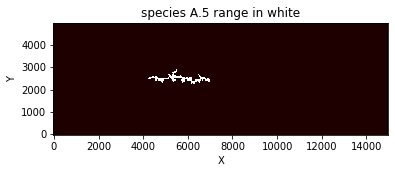

In [38]:
mask = species_A5.range_mask

imshow_grid(mg, mask, plot_name='species A.5 range in white', allow_colorbar=False)

We can confirm that the parent species of species A.5 is one of the initial species using the `parent_species` attribute.

In [39]:
species_A5.parent_species.identifier

('A', 0)

Species A.0 is one of the initial species, and became pseudoextinct as it speciated to species A1...A9 when the zone fragmented prior to time 2. The same sequence of events occurred for clade B. This phylogeny is explained by the 2 pseudoextinctions, 18 speciations, 20 total species, and 2 zone captures followed by 9 zones fragmentations.